In [1]:
from captcha.image import ImageCaptcha
from PIL import Image
import os
import sys
import time
from numpy import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import string
slim = tf.contrib.slim

D:\Users\tommy\Anaconda3\envs\tensorflow_gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# 1. 驗證碼生成

In [2]:
CHAR_SET_N = [str(i) for i in range(10)]
CHAR_SET_A = [chr(i) for i in range(ord('A'), ord('F')+1)]
CHAR_SET=CHAR_SET_N+CHAR_SET_A
NUM_CHAR_SET = len(CHAR_SET)
print(CHAR_SET)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F']


In [3]:
# 隨機生成4個字元
def random_captcha_text(CHAR_SET, captcha_size=4):
    return ''.join(random.choice(CHAR_SET, 4))

# 生成對應字元的驗證碼
def gen_captcha_text_and_image(path):
    image_ = ImageCaptcha()
    captcha_text = random_captcha_text(CHAR_SET)
    captcha = image_.generate(captcha_text)
    image_.write(captcha_text, path + captcha_text + '.png')

在 <font color=#2ECC71>path</font> 資料夾中生成 <font color=#E74C3C>num</font> 張驗證碼圖片，當超過生成圖片數量上限，將不會再生成

In [4]:
path = 'captcha/images/'
num = 10000

if not os.path.exists(path):
    os.makedirs(path)
    
now_num = len(os.listdir(path))
while(now_num < num):
    gen_captcha_text_and_image(path)
    now_num = len(os.listdir(path))
    sys.stdout.write('\r>> Creating image %d/%d' % (now_num, num))
    sys.stdout.flush()
sys.stdout.write('\n')
sys.stdout.flush()

# 2. 數據集前處理


取得驗證碼圖片的檔案路徑，並分成訓練集和測試集

In [5]:
def get_filenames(dataset_dir):
    captcha_names = []
    for filename in sorted(os.listdir(dataset_dir)):
        path = os.path.join(dataset_dir, filename)
        captcha_names.append(path)
    return captcha_names

image_filenames = get_filenames(path)    # 取得所有驗證碼圖片的檔案路徑
random.shuffle(image_filenames)          # 打亂驗證碼圖片順序

n_train = 8000    # 訓練集數量
train_filenames = image_filenames[:n_train]    # 訓練集(train set)驗證碼圖片的檔案路徑
test_filenames = image_filenames[n_train:]     # 測試集(test set)驗證碼圖片的檔案路徑

# SHOW
train_filenames[:5]

['captcha/images/5637.png',
 'captcha/images/52BA.png',
 'captcha/images/8085.png',
 'captcha/images/D274.png',
 'captcha/images/1574.png']

將檔案轉換成資料集特徵(圖片以及標籤)

In [6]:
def convert_dataset(filenames):
    
    images = []
    labels = []
    
    for i, filename in enumerate(filenames):
        sys.stdout.write('\r>> Converting image and label %d/%d' % (i + 1, len(filenames)))
        sys.stdout.flush()
        time.sleep(0.0001)
        
        # 處理圖片
        im = Image.open(filename)    # 讀取圖片(彩色RGB)
        im = im.convert('L')         # 轉換成灰階圖片(byte:0~255)
        im = np.asarray(im)          # Convert PIL to numpy
        im = im.astype(float)        # dtype uint8 to float
        im = im / 255.0              # 0 to 1
        im = np.subtract(im, 0.5)    # -0.5 to 0.5
        im = np.multiply(im, 2.0)    # -1 to 1
        
        # 處理標籤
        label = filename.split('/')[-1][:4]    # 藉由檔案名稱來提取驗證碼(4位數字)
        
        # append feature
        images.append(im)
        labels.append(label)
    
    sys.stdout.write('\n')
    sys.stdout.flush()
    
    return np.array(images), np.array(labels)

X_train, y_train = convert_dataset(train_filenames)
X_test, y_test = convert_dataset(test_filenames)

# SHOW
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

>> Converting image and label 8000/8000
>> Converting image and label 2000/2000
X_train: (8000, 60, 160)
y_train: (8000,)
X_test: (2000, 60, 160)
y_test: (2000,)


# 3. 檢測數據集正確性
隨機指定訓練集中一個圖片和標籤，並用matplotlib畫出，人工檢查圖片是否和標籤對應

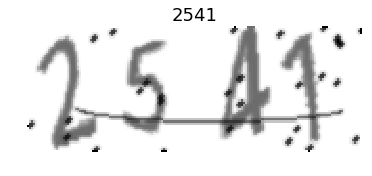

In [7]:
idx = 72
plt.imshow(X_train[idx], cmap='gray')
plt.title(y_train[idx], fontsize=18)
plt.axis('off');

# 4. 建構CNN網路

In [8]:
LEARNING_RATE = 0.0006    # 初始學習率
EPOCHS = 50              # 輪 or 時期
BATCH_SIZE = 100         # 批次大小

In [9]:
def captcha_network(inputs, num_classes, scope_name='captcha_network'):
    
    with tf.variable_scope(scope_name):
        
        x = slim.conv2d(inputs, 64, [3, 3], 1, padding='VALID', scope='conv1')
        
        x = slim.max_pool2d(x, [2, 2], 2, scope='pool1')
        
        x = slim.conv2d(x, 128, [3, 3], 1, padding='VALID', scope='conv2')
        
        x = slim.max_pool2d(x, [2, 2], 2, scope='pool2')
        
        x = slim.conv2d(x, 256, [3, 3], 1, padding='VALID', scope='conv3')
        
        x = slim.max_pool2d(x, [2, 2], 2, scope='pool3')
        
        x = slim.flatten(x, scope='flatten')
        
        x = slim.fully_connected(x, 1024, scope='fc1')
        
        x = slim.dropout(x, 0.4, scope='dropout1')
        
        logit0 = slim.fully_connected(x, num_classes, scope='task0')
        
        logit1 = slim.fully_connected(x, num_classes, scope='task1')
        
        logit2 = slim.fully_connected(x, num_classes, scope='task2')
        
        logit3 = slim.fully_connected(x, num_classes, scope='task3')
    
    return logit0, logit1, logit2, logit3

In [10]:
X = tf.placeholder(tf.float32, [None, 60, 160])
y0 = tf.placeholder(tf.float32, [None])
y1 = tf.placeholder(tf.float32, [None])
y2 = tf.placeholder(tf.float32, [None])
y3 = tf.placeholder(tf.float32, [None])

X_reshape = tf.expand_dims(X, -1)    # 將尺寸1插入張量的維度
logit0, logit1, logit2, logit3 = captcha_network(X_reshape, NUM_CHAR_SET)

one_hot_label0 = tf.one_hot(indices=tf.cast(y0, tf.int32), depth=NUM_CHAR_SET)
one_hot_label1 = tf.one_hot(indices=tf.cast(y1, tf.int32), depth=NUM_CHAR_SET)
one_hot_label2 = tf.one_hot(indices=tf.cast(y2, tf.int32), depth=NUM_CHAR_SET)
one_hot_label3 = tf.one_hot(indices=tf.cast(y3, tf.int32), depth=NUM_CHAR_SET)

with tf.variable_scope('Loss'):
    loss0 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=one_hot_label0, logits=logit0))
    loss1 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=one_hot_label1, logits=logit1))
    loss2 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=one_hot_label2, logits=logit2))
    loss3 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=one_hot_label3, logits=logit3))

total_loss = (loss0 + loss1 + loss2 + loss3) / 4.0
train_op = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(total_loss)

with tf.variable_scope('Accuracy'):
    
    y_pred0 = tf.nn.softmax(logit0)
    y_pred1 = tf.nn.softmax(logit1)
    y_pred2 = tf.nn.softmax(logit2)
    y_pred3 = tf.nn.softmax(logit3)
    
    correct_pre0 = tf.equal(tf.argmax(one_hot_label0, 1), tf.argmax(y_pred0, 1))
    correct_pre1 = tf.equal(tf.argmax(one_hot_label1, 1), tf.argmax(y_pred1, 1))
    correct_pre2 = tf.equal(tf.argmax(one_hot_label2, 1), tf.argmax(y_pred2, 1))
    correct_pre3 = tf.equal(tf.argmax(one_hot_label3, 1), tf.argmax(y_pred3, 1))
    
    accuracy0 = tf.reduce_mean(tf.cast(correct_pre0, tf.float32))
    accuracy1 = tf.reduce_mean(tf.cast(correct_pre1, tf.float32))
    accuracy2 = tf.reduce_mean(tf.cast(correct_pre2, tf.float32))
    accuracy3 = tf.reduce_mean(tf.cast(correct_pre3, tf.float32))

# 4. 訓練

In [11]:
def randomize(x, y):
    permutation = np.random.permutation(y.shape[0])
    shuffled_x = x[permutation, :]
    shuffled_y = y[permutation]
    return shuffled_x, shuffled_y

def get_next_batch(x, y, start, end):
    x_batch = x[start:end]
    y_batch = y[start:end]
    return x_batch, y_batch

def encode_character(c):
    if c in['0','1','2','3','4','5','6','7','8','9']:
        return int(c)
    else:
        return ord(c)-55
nt

def split_batch_label(b_label):
    b_label0 = [c[0] for c in b_label]
    b_label1 = [c[1] for c in b_label]
    b_label2 = [c[2] for c in b_label]
    b_label3 = [c[3] for c in b_label]
    
    b_label0 = list(map(encode_character, b_label0))
    b_label1 = list(map(encode_character, b_label1))
    b_label2 = list(map(encode_character, b_label2))
    b_label3 = list(map(encode_character, b_label3))
    return b_label0, b_label1, b_label2, b_label3

In [12]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

NUM_ITERATION = int(len(y_train) / BATCH_SIZE)         # 跑完一個 epoch 所需要的 iteration 次數
NUM_ITERATION_TEST = int(len(y_test) / BATCH_SIZE)     # 跑完一個 test set 所需要的 iteration 次數

for epoch in range(EPOCHS):
    print('___________________________________________________________________________')
    print('Epoch: {}'.format(epoch + 1))
    print('---------------------------------------------------------------------------')
    
    X_train, y_train = randomize(X_train, y_train)    # 打亂訓練集，避免每次批次都是相同的圖片分布

    for iteration in range(NUM_ITERATION):
        
        # 批次處理
        start = iteration * BATCH_SIZE
        end = start + BATCH_SIZE
        batch_X, batch_y = get_next_batch(X_train, y_train, start, end)
        batch_y0, batch_y1, batch_y2, batch_y3 = split_batch_label(batch_y)
        
        # 執行網路權重優化(run optimizer op)
        feed_dict_batch = {X: batch_X, y0: batch_y0, y1: batch_y1, y2: batch_y2, y3: batch_y3}
        sess.run(train_op, feed_dict=feed_dict_batch)
        
        # 每 10 次 iteration，印出訓練集的 Loss 以及 Accuracy
        if (iteration + 1) % 10 == 0:
            
            # 取得該批次的 loss 以及 Accuracy
            loss, acc0, acc1, acc2, acc3 = sess.run([total_loss, accuracy0, accuracy1, 
                                                     accuracy2, accuracy3], feed_dict=feed_dict_batch)
            
            print('Iteration: {:2d}/{}\t loss: {:.3f}\t Accuracy: {:.2f}, {:.2f}, {:.2f}, {:.2f}'.
                  format(iteration + 1, NUM_ITERATION, loss, acc0, acc1, acc2, acc3))


    batch_loss, batch_acc0, batch_acc1, batch_acc2, batch_acc3 = [], [], [], [], []    # 批次損失以及批次準確率
    
    # 每次 epoch 結束都會印出測試集的 Loss 以及 Accuracy
    for iteration in range(NUM_ITERATION_TEST):
        
        # 批次處理
        start = iteration * BATCH_SIZE
        end = start + BATCH_SIZE
        batch_X, batch_y = get_next_batch(X_test, y_test, start, end)
        batch_y0, batch_y1, batch_y2, batch_y3 = split_batch_label(batch_y)
        
        # 取得該批次的 loss 以及 Accuracy
        feed_dict_test = {X: batch_X, y0: batch_y0, y1: batch_y1, y2: batch_y2, y3: batch_y3}
        loss, acc0, acc1, acc2, acc3 = sess.run([total_loss, accuracy0, accuracy1, accuracy2, accuracy3],
                                                feed_dict=feed_dict_test)
        batch_loss.append(loss)
        batch_acc0.append(acc0)
        batch_acc1.append(acc1)
        batch_acc2.append(acc2)
        batch_acc3.append(acc3)
        
    # 計算平均 loss 以及 Accuracy
    avg_loss = np.mean(batch_loss)
    avg_acc0 = np.mean(batch_acc0)
    avg_acc1 = np.mean(batch_acc1)
    avg_acc2 = np.mean(batch_acc2)
    avg_acc3 = np.mean(batch_acc3)

    print('---------------------------------------------------------------------------')
    print('test_loss: {:.3f}\t Test Accuracy: {:.2f}, {:.2f}, {:.2f}, {:.2f}'.
          format(avg_loss, avg_acc0, avg_acc1, avg_acc2, avg_acc3))
    print('___________________________________________________________________________\n\n')

___________________________________________________________________________
Epoch: 1
---------------------------------------------------------------------------
Iteration: 10/80	 loss: 2.774	 Accuracy: 0.08, 0.08, 0.04, 0.06
Iteration: 20/80	 loss: 2.771	 Accuracy: 0.06, 0.09, 0.07, 0.11
Iteration: 30/80	 loss: 2.772	 Accuracy: 0.03, 0.08, 0.04, 0.09
Iteration: 40/80	 loss: 2.772	 Accuracy: 0.07, 0.07, 0.06, 0.06
Iteration: 50/80	 loss: 2.772	 Accuracy: 0.05, 0.07, 0.10, 0.07
Iteration: 60/80	 loss: 2.766	 Accuracy: 0.10, 0.10, 0.06, 0.06
Iteration: 70/80	 loss: 2.765	 Accuracy: 0.12, 0.09, 0.10, 0.06
Iteration: 80/80	 loss: 2.751	 Accuracy: 0.09, 0.03, 0.07, 0.10
---------------------------------------------------------------------------
test_loss: 2.760	 Test Accuracy: 0.09, 0.09, 0.08, 0.11
___________________________________________________________________________


___________________________________________________________________________
Epoch: 2
--------------------------------

Iteration: 30/80	 loss: 0.500	 Accuracy: 0.93, 0.84, 0.77, 0.89
Iteration: 40/80	 loss: 0.512	 Accuracy: 0.88, 0.85, 0.77, 0.84
Iteration: 50/80	 loss: 0.631	 Accuracy: 0.89, 0.79, 0.78, 0.76
Iteration: 60/80	 loss: 0.579	 Accuracy: 0.93, 0.88, 0.67, 0.81
Iteration: 70/80	 loss: 0.508	 Accuracy: 0.86, 0.85, 0.76, 0.84
Iteration: 80/80	 loss: 0.523	 Accuracy: 0.91, 0.87, 0.78, 0.81
---------------------------------------------------------------------------
test_loss: 1.121	 Test Accuracy: 0.78, 0.62, 0.53, 0.70
___________________________________________________________________________


___________________________________________________________________________
Epoch: 11
---------------------------------------------------------------------------
Iteration: 10/80	 loss: 0.423	 Accuracy: 0.94, 0.88, 0.78, 0.89
Iteration: 20/80	 loss: 0.527	 Accuracy: 0.91, 0.83, 0.71, 0.84
Iteration: 30/80	 loss: 0.470	 Accuracy: 0.96, 0.88, 0.80, 0.85
Iteration: 40/80	 loss: 0.408	 Accuracy: 0.87, 0.90,

Iteration: 70/80	 loss: 0.232	 Accuracy: 0.93, 0.87, 0.92, 0.92
Iteration: 80/80	 loss: 0.269	 Accuracy: 0.94, 0.98, 0.85, 0.89
---------------------------------------------------------------------------
test_loss: 1.139	 Test Accuracy: 0.80, 0.64, 0.59, 0.74
___________________________________________________________________________


___________________________________________________________________________
Epoch: 20
---------------------------------------------------------------------------
Iteration: 10/80	 loss: 0.236	 Accuracy: 0.97, 0.91, 0.89, 0.91
Iteration: 20/80	 loss: 0.308	 Accuracy: 0.94, 0.90, 0.87, 0.91
Iteration: 30/80	 loss: 0.238	 Accuracy: 0.95, 0.98, 0.88, 0.87
Iteration: 40/80	 loss: 0.257	 Accuracy: 0.96, 0.94, 0.84, 0.93
Iteration: 50/80	 loss: 0.247	 Accuracy: 0.96, 0.93, 0.89, 0.90
Iteration: 60/80	 loss: 0.312	 Accuracy: 0.97, 0.93, 0.86, 0.87
Iteration: 70/80	 loss: 0.230	 Accuracy: 0.95, 0.92, 0.90, 0.93
Iteration: 80/80	 loss: 0.235	 Accuracy: 0.96, 0.96,

Iteration: 10/80	 loss: 0.166	 Accuracy: 0.98, 0.96, 0.90, 0.96
Iteration: 20/80	 loss: 0.186	 Accuracy: 0.96, 0.95, 0.87, 1.00
Iteration: 30/80	 loss: 0.196	 Accuracy: 0.97, 0.93, 0.90, 0.96
Iteration: 40/80	 loss: 0.147	 Accuracy: 0.96, 0.99, 0.88, 0.98
Iteration: 50/80	 loss: 0.217	 Accuracy: 0.97, 0.93, 0.84, 0.96
Iteration: 60/80	 loss: 0.201	 Accuracy: 0.99, 0.98, 0.82, 0.97
Iteration: 70/80	 loss: 0.143	 Accuracy: 0.96, 0.95, 0.94, 0.95
Iteration: 80/80	 loss: 0.167	 Accuracy: 0.98, 0.93, 0.90, 0.98
---------------------------------------------------------------------------
test_loss: 1.186	 Test Accuracy: 0.81, 0.65, 0.59, 0.77
___________________________________________________________________________


___________________________________________________________________________
Epoch: 30
---------------------------------------------------------------------------
Iteration: 10/80	 loss: 0.130	 Accuracy: 0.99, 0.98, 0.91, 0.97
Iteration: 20/80	 loss: 0.135	 Accuracy: 0.97, 0.99,

Iteration: 50/80	 loss: 0.159	 Accuracy: 0.98, 0.96, 0.89, 0.98
Iteration: 60/80	 loss: 0.153	 Accuracy: 0.95, 0.95, 0.92, 0.96
Iteration: 70/80	 loss: 0.135	 Accuracy: 0.97, 0.97, 0.89, 0.96
Iteration: 80/80	 loss: 0.100	 Accuracy: 0.97, 0.98, 0.92, 0.98
---------------------------------------------------------------------------
test_loss: 1.206	 Test Accuracy: 0.82, 0.67, 0.60, 0.78
___________________________________________________________________________


___________________________________________________________________________
Epoch: 39
---------------------------------------------------------------------------
Iteration: 10/80	 loss: 0.136	 Accuracy: 0.99, 0.98, 0.89, 0.98
Iteration: 20/80	 loss: 0.168	 Accuracy: 0.95, 0.97, 0.88, 0.96
Iteration: 30/80	 loss: 0.133	 Accuracy: 0.96, 0.98, 0.90, 0.96
Iteration: 40/80	 loss: 0.129	 Accuracy: 0.96, 0.98, 0.91, 0.99
Iteration: 50/80	 loss: 0.123	 Accuracy: 0.97, 0.96, 0.93, 0.97
Iteration: 60/80	 loss: 0.081	 Accuracy: 0.99, 0.98,

---------------------------------------------------------------------------
test_loss: 1.222	 Test Accuracy: 0.82, 0.66, 0.60, 0.79
___________________________________________________________________________


___________________________________________________________________________
Epoch: 48
---------------------------------------------------------------------------
Iteration: 10/80	 loss: 0.053	 Accuracy: 0.99, 0.99, 0.97, 0.99
Iteration: 20/80	 loss: 0.102	 Accuracy: 1.00, 0.98, 0.93, 0.96
Iteration: 30/80	 loss: 0.117	 Accuracy: 0.97, 0.99, 0.89, 0.98
Iteration: 40/80	 loss: 0.113	 Accuracy: 0.98, 0.97, 0.90, 0.99
Iteration: 50/80	 loss: 0.073	 Accuracy: 0.99, 0.98, 0.92, 0.99
Iteration: 60/80	 loss: 0.134	 Accuracy: 0.98, 0.98, 0.91, 0.98
Iteration: 70/80	 loss: 0.061	 Accuracy: 0.99, 0.98, 0.97, 0.98
Iteration: 80/80	 loss: 0.143	 Accuracy: 0.98, 0.95, 0.92, 0.96
---------------------------------------------------------------------------
test_loss: 1.205	 Test Accuracy: 0.82, 0

In [13]:
def decode_character(x):
    if x<10:
        return x
    else:
        return chr(x+55)

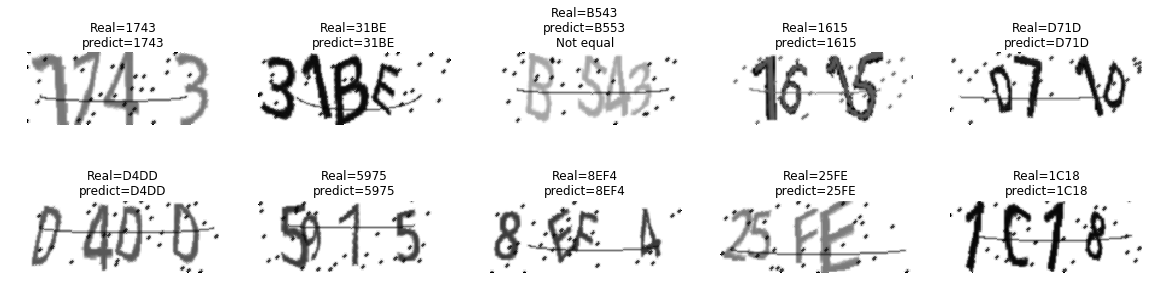

In [14]:
X_train, y_train = randomize(X_train, y_train)
batch_X, batch_y = get_next_batch(X_train, y_train, 0, 10)
pred0, pred1, pred2, pred3 = sess.run([y_pred0, y_pred1, y_pred2, y_pred3], feed_dict={X: batch_X})

pred0 = np.argmax(pred0, axis=1)
pred1 = np.argmax(pred1, axis=1)
pred2 = np.argmax(pred2, axis=1)
pred3 = np.argmax(pred3, axis=1)

pred0 = list(map(decode_character,pred0))
pred1 = list(map(decode_character,pred1))
pred2 = list(map(decode_character,pred2))
pred3 = list(map(decode_character,pred3))

fig = plt.figure(figsize=(20, 5))
for i in range(10):
    # 顯示圖片
    ax = plt.subplot(2, 5, i+1)
    ax.imshow(batch_X[i], cmap='gray')
    ax.axis('off')
    
    # 處理標籤
    title_real = batch_y[i]
    title_predict = str(pred0[i]) + str(pred1[i]) + str(pred2[i]) + str(pred3[i])
    title = 'Real=' + title_real + '\n' + 'predict=' + title_predict
    
    # 如果預測錯誤，將顯示不相等
    if title_real != title_predict:
        title += '\n' + 'Not equal'
    ax.set_title(title)

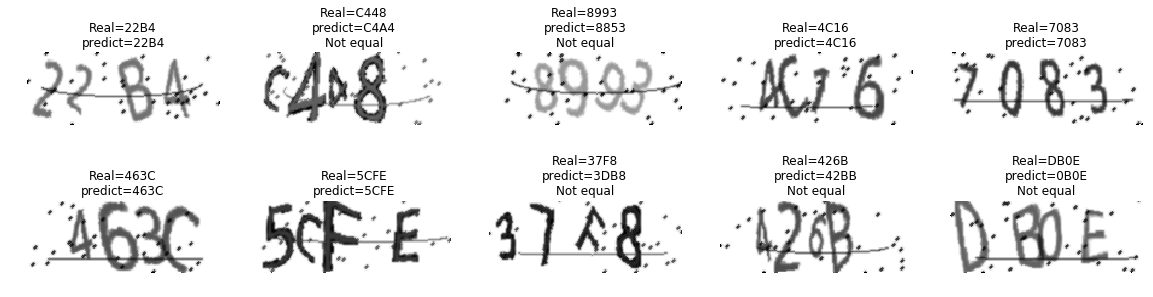

In [19]:
X_test, y_test = randomize(X_test, y_test)
batch_X, batch_y = get_next_batch(X_test, y_test, 0, 10)
pred0, pred1, pred2, pred3 = sess.run([y_pred0, y_pred1, y_pred2, y_pred3], feed_dict={X: batch_X})

pred0 = np.argmax(pred0, axis=1)
pred1 = np.argmax(pred1, axis=1)
pred2 = np.argmax(pred2, axis=1)
pred3 = np.argmax(pred3, axis=1)

pred0 = list(map(decode_character,pred0))
pred1 = list(map(decode_character,pred1))
pred2 = list(map(decode_character,pred2))
pred3 = list(map(decode_character,pred3))

fig = plt.figure(figsize=(20, 5))
for i in range(10):
    # 顯示圖片
    ax = plt.subplot(2, 5, i+1)
    ax.imshow(batch_X[i], cmap='gray')
    ax.axis('off')
    
    # 處理標籤
    title_real = batch_y[i]
    title_predict = str(pred0[i]) + str(pred1[i]) + str(pred2[i]) + str(pred3[i])
    title = 'Real=' + title_real + '\n' + 'predict=' + title_predict
    
    # 如果預測錯誤，將顯示不相等
    if title_real != title_predict:
        title += '\n' + 'Not equal'
    ax.set_title(title)